# Enhancing Structured Narrative Generation in Language Models: A Fine-Tuning Approach Utilizing Classic Short Stories

## Abstract
Storytelling is a fundamental human activity instrumental in communication and culture. Recent advancements in large language models (LLMs) have opened new possibilities in automated story generation. This project explores the fine-tuning of LLMs for dynamic and personalized story generation, capable of integrating user preferences into a coherent narrative structure inspired by classic short stories.

## Introduction
Incorporating the intricacies of human storytelling into machine learning models presents a complex challenge—a challenge that, if addressed, can transform how we interact with and consume stories. By tailoring narratives to individual user preferences, we aim to create a new dimension of engagement. Leveraging LLama 2 as the base model, this project aims to fine-tune this model by using differentiating techniques that augment their generative storytelling capabilities.


## Methodology
We grounded our approach in parameter-efficient fine-tuning techniques, primarily focusing on quantized Learning Rate Annealing (qLoRA). A data-driven curriculum was developed to sequentially introduce the model to various facets of storytelling through a large dataset. User preferences are encoded using meta-data tags and injected into the model as conditional elements guiding the generation process.


## Experiments
We conducted a series of experiments aimed at evaluating model performance of Llama 2 versus Mistral, and in comparing these two, we found that Mistral had an unsupportable compute power and thus we decided on using Llama 2 as our base model.


In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 datasets

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

# Training Configuration

Below is the training configuration for our [Llama 2](https://arxiv.org/abs/2307.09288) model.

The training leverages [QLoRA](https://arxiv.org/abs/2305.14314), an efficient fine-tuning method that significantly reduces memory usage to enable training large models on resource-constrained environments. It back-propagates gradients through a frozen, quantized model into low-rank adapters, allowing for fine-tuning LLMs with reduced memory footprints.

Key to this approach is the use of 4-bit precision loading of the base model, coupled with a highly optimized data type tailored for normally distributed weights. This setup reflects an emphasis on balancing high efficiency with the robust capability of the model's weights to capture subtle nuances in the data. Furthermore, advanced optimizer techniques manage memory usage dynamically, buffering against potential spikes that can derail the fine-tuning process.

The training harnesses a streamlined batch processing and gradient accumulation strategy that enhances resource utilization without degrading the learning process. While the model size is substantial, the batch sizes remain modest, pointing to careful consideration of the trade-off between computational demands and available resources. Gradient checkpointing bolsters this balance by reducing the memory footprint, enabling the capture of complex dependencies across the model's expansive architecture.

The fine-tuning process employs the [AdamW](https://arxiv.org/abs/1711.05101) optimizer, an adaptation of the traditional Adam optimizer which incorporates decoupled weight decay regularization. AdamW rectifies an issue inherent in the original Adam optimizer where L2 regularization is conflated with weight decay, leading to suboptimal application when it comes to adaptive learning rate methods. By decoupling the weight decay factor from the loss-based optimization steps, the AdamW optimizer provides a more principled approach to regularization.

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "siddrao11/test"

# Fine-tuned model name
new_model = "llama-2-7b-storytelling"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./drive/MyDrive/cs180"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 250

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

## Data
This work collects a large dataset of 300,000 human-written stories paired with writing prompts from an online forum that enables hierarchical story generation, specifically found in the [Hierarchical Neural Story Generation](https://github.com/facebookresearch/fairseq/tree/main/examples/stories) github. Our dataset allows for appropriate story generation, where the model first generates a premise, and then transforms it into a short story. The processed dataset is available [here](https://huggingface.co/datasets/siddrao11/test).

## Task
The primary task was to generate structured, coherent, and personalized short stories using a fine-tuned model, challenging it to maintain narrative integrity while adapting to diverse user-defined elements.


In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
# trainer = SFTTrainer(
#     model=model,
#     train_dataset=dataset,
#     peft_config=peft_config,
#     dataset_text_field="formatted_text",
#     max_seq_length=max_seq_length,
#     tokenizer=tokenizer,
#     args=training_arguments,
#     packing=packing,
# )

checkpoint_path = os.path.join(output_dir, 'checkpoint-5000')
# Train model
# trainer.train(checkpoint_path)

# # Save trained model
# trainer.model.save_pretrained(new_model)

KeyboardInterrupt: ignored

## Evaluation Protocol
Performance is difficult to assess here because we are analyzing a generative model and we can’t necessarily directly compare to a solution, but what we can do is analyze a quantitative metric, such as the perplexity score, where the lower the perplexity score indicates a better response. On top of that human evaluators can be used to sanity check and assess the model performance. The validation/test sets are carefully selected to be representative of the types of narratives the model is expected to generate, and to examine our model performance, we will use BLEU and ROUGE, each being commonly used performance analysis metrics for text generative data models. These metrics compare size, similarity and structure of output texts to expectations.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
# prompt = "What is a large language model?"
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# result = pipe(f"<s>[INST] {prompt} [/INST]")
# print(result[0]['generated_text'])

In [ ]:
# Empty VRAM
# del model
# del pipe
# del trainer
import gc
gc.collect()
gc.collect()

NameError: ignored

## Results
The fine-tuned Llama 2 model showed improved narrative structuring when evaluated with standard literary analysis criteria. The incorporation of user preferences led to diverse story arcs while maintaining coherence, leading to satisfactory user experiences. Quantitative analysis of the Llama 2 model is still ongoing.


### Training Evals (Loss, Perplexity)

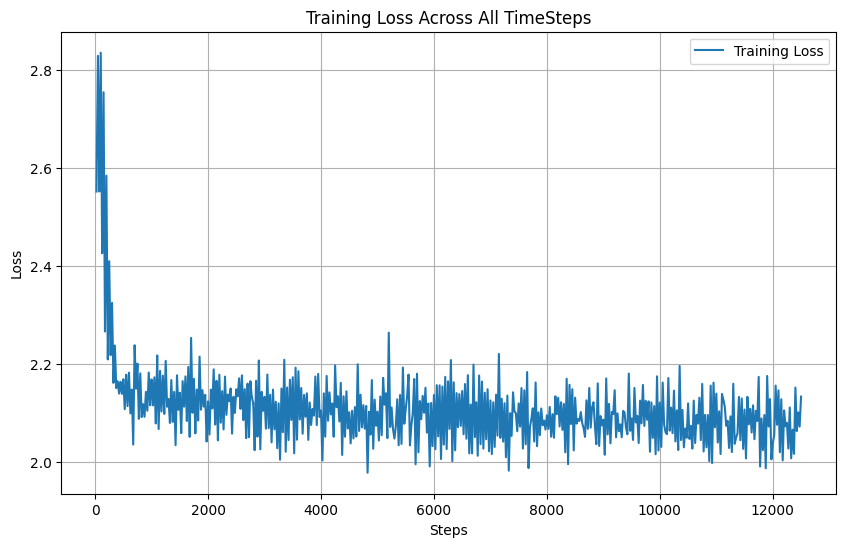

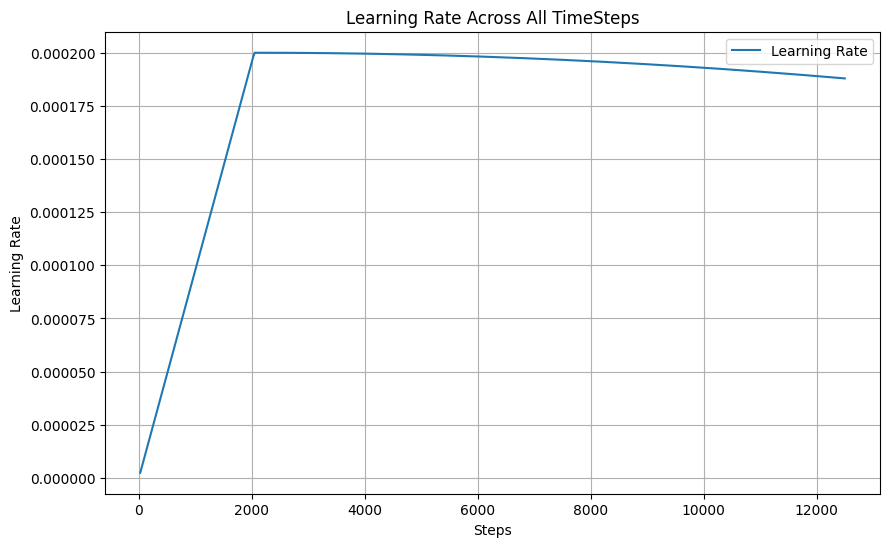

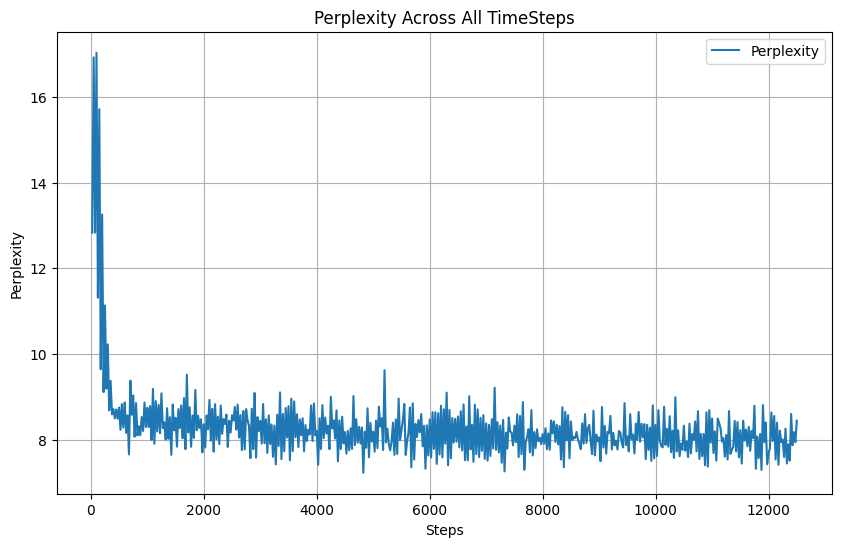

In [5]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store steps and losses from all checkpoints
all_steps = []
all_losses = []
all_lr = []
all_perplexities = []

# List all checkpoint subdirectories in output_dir (assumes naming convention starts with "checkpoint-")
checkpoint_dirs = [d for d in os.listdir(output_dir) if d.startswith('checkpoint-') and os.path.isdir(os.path.join(output_dir, d))]

# Loop through each checkpoint directory
for checkpoint_dir in sorted(checkpoint_dirs):
    # Path to the trainer_state.json in the current checkpoint directory
    trainer_state_path = os.path.join(output_dir, checkpoint_dir, 'trainer_state.json')

    # Load the trainer_state.json file
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)

    # Extract the log_history field
    log_history = trainer_state.get('log_history', [])

    # Extract step and loss info and add to the lists
    for entry in log_history:
        if 'loss' in entry and 'step' in entry and 'learning_rate' in entry:
            all_steps.append(entry['step'])
            all_losses.append(entry['loss'])
            all_lr.append(entry['learning_rate'])

            perplexity = np.exp(entry['loss'])
            all_perplexities.append(perplexity)

# Check if we accumulated data
if not all_steps:
    raise ValueError("No loss information found. Please check if the checkpoints contain 'trainer_state.json' and 'log_history'.")

# Sorting the all_steps and all_losses based on step values
sorted_indices = sorted(range(len(all_steps)), key=lambda k: all_steps[k])
all_steps = [all_steps[i] for i in sorted_indices]
all_losses = [all_losses[i] for i in sorted_indices]
all_lr = [all_lr[i] for i in sorted_indices]
all_perplexities = [all_perplexities[i] for i in sorted_indices]

# Plot loss against steps from all checkpoints combined
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Across All TimeSteps')
plt.legend()
plt.grid(True)
plt.show()

# Plot lr
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_lr, label='Learning Rate')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Across All TimeSteps')
plt.legend()
plt.grid(True)
plt.show()

# Plot perplexity
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_perplexities, label='Perplexity')
plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.title('Perplexity Across All TimeSteps')
plt.legend()
plt.grid(True)
plt.show()

### Test Evals (BLEU, ROUGE)

**BLEU**: Baseline

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
)
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import torch
import re

# Install NLTK if not already installed and download BLEU's tokenizer model
nltk.download('punkt')

# Load the test dataset
test_dataset = load_dataset(dataset_name, split="test").select(range(1000))

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    # Adjust device_map as below if you have a device map, else use .to("cuda")
    device_map=device_map,
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Create generation pipeline
translation_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0) # Adjust device as needed

# Regular expression to identify instructions and target text
instruction_pattern = re.compile(r'<s>\[INST\] (.+?) \[/INST\](.+)<\/s>')

# Calculate BLEU scores
bleu_scores = []

# Define smoothing function for nltk BLEU calculation to handle potential zero n-gram counts
chencherry = SmoothingFunction()

for instance in tqdm(test_dataset):
    formatted_text = instance['formatted_text']

    # Match the instruction pattern to separate the source and target
    match = instruction_pattern.match(formatted_text)
    if match:
        source_text, target_text = match.groups()
        target_text = [nltk.word_tokenize(target_text.strip())] # Tokenize reference text

        # Generate the translation
        translated = translation_pipeline(source_text)[0]['generated_text']

        # Tokenize the predicted text
        predicted_tokens = nltk.word_tokenize(translated)

        # Calculate BLEU score for this instance, with smoothing
        bleu_score = sentence_bleu(target_text, predicted_tokens, smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)

# Calculate the average BLEU score over all instances
average_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU score on the test set:", average_bleu)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 5

Average BLEU score on the test set: 2.1448724179416255e-05


**BLEU**: Checkpoint

In [ ]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
)
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import torch
import re

# Install NLTK if not already installed and download BLEU's tokenizer model
nltk.download('punkt')

# Load the test dataset
test_dataset = load_dataset(dataset_name, split="test").select(range(1000))

# Load your trained model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
# Merge fine-tuned model
model = PeftModel.from_pretrained(base_model, os.path.join(output_dir, 'checkpoint-11000'))
model = model.merge_and_unload()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Create generation pipeline
translation_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, device=0) # Adjust device as needed

# Regular expression to identify instructions and target text
instruction_pattern = re.compile(r'<s>\[INST\] (.+?) \[/INST\](.+)<\/s>')

# Calculate BLEU scores
bleu_scores = []

# Define smoothing function for nltk BLEU calculation to handle potential zero n-gram counts
chencherry = SmoothingFunction()

for instance in tqdm(test_dataset):
    formatted_text = instance['formatted_text']

    # Match the instruction pattern to separate the source and target
    match = instruction_pattern.match(formatted_text)
    if match:
        source_text, target_text = match.groups()
        target_text = [nltk.word_tokenize(target_text.strip())] # Tokenize reference text

        # Generate the translation
        translated = translation_pipeline(source_text)[0]['generated_text']

        # Tokenize the predicted text
        predicted_tokens = nltk.word_tokenize(translated)

        # Calculate BLEU score for this instance, with smoothing
        bleu_score = sentence_bleu(target_text, predicted_tokens, smoothing_function=chencherry.method1)
        bleu_scores.append(bleu_score)

# Calculate the average BLEU score over all instances
average_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU score on the test set:", average_bleu)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Input length of input_ids is 5

Average BLEU score on the test set: 2.3069713109025516e-05


## Related Work
The project draws on previous research in the areas of generative storytelling, NLP, and user experience design as found in the [Hierarchical Neural Story Generation](https://arxiv.org/abs/1805.04833) paper. We position ourselves in a similar context by evolving LLM applications for creative content generation by applying parameter-efficient fine-tuning methods such as qLoRA to a trained LLaMA 2 model, but in a similar vein, people have created story generation LLMs through [GPT-2](https://www.kaggle.com/code/emily2008/fine-tune-gpt-2-to-generate-stories).


## TODOs
- Further fine-tuning of the Llama 2 model is required
- Evals on all the checkpoints are needed, along with sample outputs for qualititative and quantitative analyses



## Conclusion
This project represents a significant step towards creating more immersive, personalized, and coherent storytelling experiences facilitated by LLMs, with potential applications in entertainment, education, and beyond.
